# MLOps-zoomcamp
## Homework: Intro
The goal of this homework is to train a simple model for predicting the duration of a ride, following module 1 in the course


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### Downloading the Data

In [2]:
train_df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')
train_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [3]:
columns_n = len(train_df.columns)
print(f'{columns_n} columns were found!')

19 columns were found!


## Computing duration

In [4]:
train_df['duration'] = (train_df['tpep_dropoff_datetime'] - train_df['tpep_pickup_datetime']).dt.total_seconds() / 60

<AxesSubplot:>

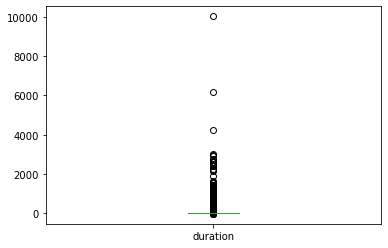

In [5]:
train_df['duration'].plot(kind='box')

In [6]:
std_duration = np.std(train_df['duration'])
print('Standard Deviation of ride duration:', std_duration)

Standard Deviation of ride duration: 42.5943442974141


## Dropping outliers in duration

In [7]:
clean_train_df = train_df[(train_df['duration']>=1) & (train_df['duration']<=60)]

In [8]:
retained_ratio = clean_train_df.shape[0] / train_df.shape[0]
print(f'Fraction of dataset retained: {retained_ratio * 100:.1f}%')

Fraction of dataset retained: 98.1%


## One-hot encoding

In [9]:
dv = DictVectorizer()

In [10]:
clean_train_df['PULocationID'] = clean_train_df['PULocationID'].astype(str)
clean_train_df['DOLocationID'] = clean_train_df['DOLocationID'].astype(str)

/tmp/ipykernel_40556/2480308786.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_train_df['PULocationID'] = clean_train_df['PULocationID'].astype(str)
/tmp/ipykernel_40556/2480308786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_train_df['DOLocationID'] = clean_train_df['DOLocationID'].astype(str)


In [11]:
dicts = clean_train_df[['PULocationID','DOLocationID']].to_dict(orient='records')
dicts[:10]

[{'PULocationID': '161', 'DOLocationID': '141'},
 {'PULocationID': '43', 'DOLocationID': '237'},
 {'PULocationID': '48', 'DOLocationID': '238'},
 {'PULocationID': '138', 'DOLocationID': '7'},
 {'PULocationID': '107', 'DOLocationID': '79'},
 {'PULocationID': '161', 'DOLocationID': '137'},
 {'PULocationID': '239', 'DOLocationID': '143'},
 {'PULocationID': '142', 'DOLocationID': '200'},
 {'PULocationID': '164', 'DOLocationID': '236'},
 {'PULocationID': '141', 'DOLocationID': '107'}]

In [12]:
X_train = dv.fit_transform(dicts)
print('Matrix shape:', X_train.shape)

Matrix shape: (3009173, 515)


## Training a model

In [13]:
y_train = clean_train_df['duration']

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
preds_train = model.predict(X_train)

In [16]:
RMSE_Train = mean_squared_error(y_train, preds_train, squared=False)
print('RMSE on training data:', RMSE_Train)

RMSE on training data: 7.649261027826866


## Evaluating the model

In [17]:
def read_dataframe(file_name):
    df = pd.read_parquet(file_name)
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60
    df = df[(df['duration']>=1) & (df['duration']<=60)]
    return df

In [18]:
val_df = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [19]:
val_df['PULocationID'] = val_df['PULocationID'].astype(str)
val_df['DOLocationID'] = val_df['DOLocationID'].astype(str)
y_val = val_df['duration']

In [20]:
dicts_feb = val_df[['PULocationID','DOLocationID']].to_dict(orient='records')
X_val = dv.transform(dicts_feb)

In [21]:
X_val.shape

(2855951, 515)

In [22]:
preds_val = model.predict(X_val)

In [23]:
RMSE_eval = mean_squared_error(y_val, preds_val, squared=False)
print('RMSE on validation data:', RMSE_eval)

RMSE on validation data: 7.811832641626525
